In [1]:
import numpy as np
import pandas as pd

import confusion_plot
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer

# Logistic Regression

Instead of regressively modeling a continuous value, in this notebook we're going to "classify" a discrete value by using a logistic (or sigmoid) function:

$$ p(y|X) = \frac{e^{b + w X}}{1 + e^{b + w X}} $$

Below, let's plot this function to get an intuition for why we're able to use it to categorize ("classify") inputs into discrete outputs:

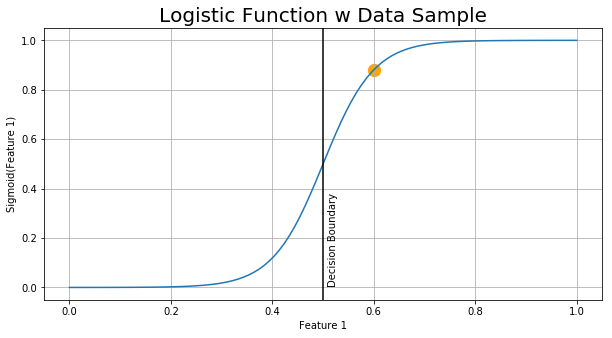

In [2]:
logistic = lambda b, w, x: np.exp(b + w * x) / (1 + np.exp(b + w * x))
params = [-10, 20]
sample = 0.6

X = np.linspace(0, 1, 100)
y = logistic(params[0], params[1], X)

plt.figure(figsize=(10,5))
plt.plot(X, y)
plt.scatter(sample, logistic(params[0], params[1], sample), color='orange', s=150)
plt.axvline(x=0.5, color='k')
plt.title('Logistic Function w Data Sample', fontsize=20)
plt.xlabel('Feature 1')
plt.ylabel('Sigmoid(Feature 1)')
plt.text(0.51, 0.35, 'Decision Boundary', rotation=90)
plt.grid()
plt.show()

The position on this function is the probability that the sample belongs to class 1. We define some threshold (50% above) for class membership.

# Load and Clean Data

In [3]:
titanic = pd.read_csv('../../data/titanic/titanic.csv')

In [4]:
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


In [5]:
titanic.dtypes

Age            float64
Cabin           object
Embarked        object
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex             object
SibSp            int64
Survived         int64
Ticket          object
dtype: object

|Variable|	Definition	|Key|
|---|---|---|
|survival	|Survival|	0 = No, 1 = Yes|
|pclass	|Ticket class	|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex	|Sex	||
|Age	|Age in years	||
|sibsp	|# of siblings / spouses aboard the Titanic	||
|parch	|# of parents / children aboard the Titanic	||
|ticket	|Ticket number	||
|fare	|Passenger fare	||
|cabin	|Cabin number	||
|embarked	|Port of Embarkation|	C = Cherbourg, Q = Queenstown, S = Southampton|


Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [6]:
titanic.shape

(1309, 12)

In [7]:
titanic.drop(['Name','Ticket'], axis=1, inplace=True)

Note I've dropped ticket number above. That could be a mistake. It's possible that there's a correlation between this feature and the model output. For example, if parents and children have the same ticket number, if the parents survive there's a greater chance the kids do, as well.

# Feature Engineering

In [8]:
titanic['Family Members'] = titanic['Parch'] + titanic['SibSp']

In [9]:
titanic['Pclass'].unique()

array([3, 1, 2])

In [10]:
titanic['Pclass category'] = pd.DataFrame(titanic['Pclass']).applymap(lambda x: str(x))

In [11]:
titanic.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Family Members,Pclass category
0,22.0,NaN,S,7.2500,0,1,3,male,1,0,1,3
1,38.0,C85,C,71.2833,0,2,1,female,1,1,1,1
2,26.0,NaN,S,7.9250,0,3,3,female,0,1,0,3
3,35.0,C123,S,53.1000,0,4,1,female,1,1,1,1
4,35.0,NaN,S,8.0500,0,5,3,male,0,0,0,3


# Categorical Variable NaN Fill

In [12]:
for i in list(titanic.columns):
    print('{} contains NaNs: '.format(i), np.amax(titanic[i].isnull()))

Age contains NaNs:  True
Cabin contains NaNs:  True
Embarked contains NaNs:  True
Fare contains NaNs:  True
Parch contains NaNs:  False
PassengerId contains NaNs:  False
Pclass contains NaNs:  False
Sex contains NaNs:  False
SibSp contains NaNs:  False
Survived contains NaNs:  False
Family Members contains NaNs:  False
Pclass category contains NaNs:  False


In [13]:
titanic['Embarked'] = titanic['Embarked'].fillna('NaN')

In [14]:
titanic['Cabin'] = titanic['Cabin'].fillna('NaN')

In [15]:
titanic.fillna('NaN', inplace=True)

# One Hot Encoding

In [16]:
one_hot = pd.get_dummies(titanic, columns=['Cabin', 'Embarked', 'Sex', 'Pclass category'])

In [17]:
with pd.option_context('display.max_columns', None):
    display(one_hot.head())

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,Family Members,Cabin_A10,Cabin_A11,Cabin_A14,Cabin_A16,Cabin_A18,Cabin_A19,Cabin_A20,Cabin_A21,Cabin_A23,Cabin_A24,Cabin_A26,Cabin_A29,Cabin_A31,Cabin_A32,Cabin_A34,Cabin_A36,Cabin_A5,Cabin_A6,Cabin_A7,Cabin_A9,Cabin_B10,Cabin_B101,Cabin_B102,Cabin_B11,Cabin_B18,Cabin_B19,Cabin_B20,Cabin_B22,Cabin_B24,Cabin_B26,Cabin_B28,Cabin_B3,Cabin_B30,Cabin_B35,Cabin_B36,Cabin_B37,Cabin_B38,Cabin_B39,Cabin_B4,Cabin_B41,Cabin_B42,Cabin_B45,Cabin_B49,Cabin_B5,Cabin_B50,Cabin_B51 B53 B55,Cabin_B52 B54 B56,Cabin_B57 B59 B63 B66,Cabin_B58 B60,Cabin_B61,Cabin_B69,Cabin_B71,Cabin_B73,Cabin_B77,Cabin_B78,Cabin_B79,Cabin_B80,Cabin_B82 B84,Cabin_B86,Cabin_B94,Cabin_B96 B98,Cabin_C101,Cabin_C103,Cabin_C104,Cabin_C105,Cabin_C106,Cabin_C110,Cabin_C111,Cabin_C116,Cabin_C118,Cabin_C123,Cabin_C124,Cabin_C125,Cabin_C126,Cabin_C128,Cabin_C130,Cabin_C132,Cabin_C148,Cabin_C2,Cabin_C22 C26,Cabin_C23 C25 C27,Cabin_C28,Cabin_C30,Cabin_C31,Cabin_C32,Cabin_C39,Cabin_C45,Cabin_C46,Cabin_C47,Cabin_C49,Cabin_C50,Cabin_C51,Cabin_C52,Cabin_C53,Cabin_C54,Cabin_C55 C57,Cabin_C6,Cabin_C62 C64,Cabin_C65,Cabin_C68,Cabin_C7,Cabin_C70,Cabin_C78,Cabin_C80,Cabin_C82,Cabin_C83,Cabin_C85,Cabin_C86,Cabin_C87,Cabin_C89,Cabin_C90,Cabin_C91,Cabin_C92,Cabin_C93,Cabin_C95,Cabin_C97,Cabin_C99,Cabin_D,Cabin_D10 D12,Cabin_D11,Cabin_D15,Cabin_D17,Cabin_D19,Cabin_D20,Cabin_D21,Cabin_D22,Cabin_D26,Cabin_D28,Cabin_D30,Cabin_D33,Cabin_D34,Cabin_D35,Cabin_D36,Cabin_D37,Cabin_D38,Cabin_D40,Cabin_D43,Cabin_D45,Cabin_D46,Cabin_D47,Cabin_D48,Cabin_D49,Cabin_D50,Cabin_D56,Cabin_D6,Cabin_D7,Cabin_D9,Cabin_E10,Cabin_E101,Cabin_E12,Cabin_E121,Cabin_E17,Cabin_E24,Cabin_E25,Cabin_E31,Cabin_E33,Cabin_E34,Cabin_E36,Cabin_E38,Cabin_E39 E41,Cabin_E40,Cabin_E44,Cabin_E45,Cabin_E46,Cabin_E49,Cabin_E50,Cabin_E52,Cabin_E58,Cabin_E60,Cabin_E63,Cabin_E67,Cabin_E68,Cabin_E77,Cabin_E8,Cabin_F,Cabin_F E46,Cabin_F E57,Cabin_F E69,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_NaN,Cabin_T,Embarked_C,Embarked_NaN,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass category_1,Pclass category_2,Pclass category_3
0,22,7.25,0,1,3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1
1,38,71.2833,0,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
2,26,7.925,0,3,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1
3,35,53.1,0,4,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0
4,35,8.05,0,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [18]:
one_hot.shape

(1309, 204)

# Shuffle

In [19]:
y = one_hot['Survived']
X = one_hot.drop('Survived', axis=1)

In [20]:
X = X.values
y = y.values

In [21]:
X, y = shuffle(X, y)

# Continuous Variable NaN Imputation

In [22]:
X

array([['NaN', 69.55, 2, ..., 0, 0, 1],
       [24.0, 69.3, 0, ..., 1, 0, 0],
       [24.0, 82.2667, 0, ..., 1, 0, 0],
       ...,
       [22.0, 8.05, 0, ..., 0, 0, 1],
       [16.0, 7.7333, 0, ..., 0, 0, 1],
       [33.0, 27.75, 2, ..., 0, 1, 0]], dtype=object)

In [23]:
imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)

In [24]:
X = imputer.fit_transform(X)

In [25]:
X

array([[29.88113767, 69.55      ,  2.        , ...,  0.        ,
         0.        ,  1.        ],
       [24.        , 69.3       ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [24.        , 82.2667    ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [22.        ,  8.05      ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [16.        ,  7.7333    ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [33.        , 27.75      ,  2.        , ...,  0.        ,
         1.        ,  0.        ]])

This is a suuuuuuper basic imputation strategy. There are many more effective ones.

### Aside: write out data for subsequent use

We don't want to have to go through the same data cleaning pipeline for every ML method we study today, so let's just write out this clean file for future use.

In [26]:
cols = list(one_hot.columns)
cols.pop(6)
cols.append('Survived')

clean = pd.DataFrame(np.hstack((X,y.reshape(-1,1))), columns=cols)

clean.to_csv('../../data/titanic/clean.csv', index=False)

### Remove Passenger IDs

In [27]:
X.shape

(1309, 203)

In [28]:
X = np.delete(X, 3, 1)

In [29]:
X.shape

(1309, 202)

# A Note on Data Balance

In [30]:
print('Percent survived: ', 100 * np.count_nonzero(titanic['Survived']) / titanic.shape[0])

Percent survived:  37.73873185637891


# Split Out Training + Validation Sets

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Random Guess "Model"

In [32]:
preds = np.random.choice([0,1], size=X_test.shape[0])

In [33]:
accuracy_score(preds, y_test)

0.5190839694656488

# Model

In [34]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
preds = clf.predict(X_test)

# Accuracy

In [36]:
accuracy_score(preds, y_test)

0.8396946564885496

In [37]:
conf = confusion_matrix(y_test, preds)

Confusion matrix, without normalization
[[74 10]
 [11 36]]


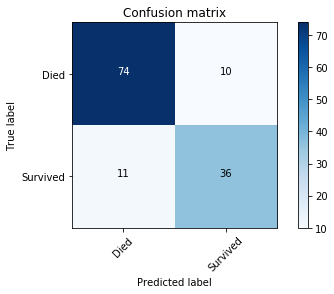

In [38]:
confusion_plot.plot_confusion_matrix(conf, classes=['Died', 'Survived'])

Normalized confusion matrix
[[0.88095238 0.11904762]
 [0.23404255 0.76595745]]


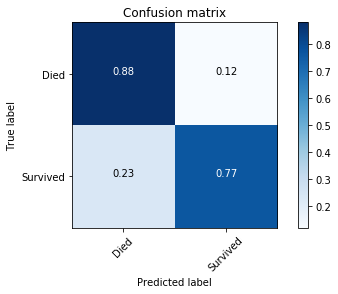

In [39]:
confusion_plot.plot_confusion_matrix(conf, classes=['Died', 'Survived'], normalize=True)